# Notebook Contents

- Loading data with pandas, munging
- Use tensorflow dataset class for fast data access
- Create a tensorflow model and use gradient tape
- Using the keras fit function 
- Using feature spaces
- Wide and deep networks
- Using metrics from scikit-learn


# Loading in the Data
In this example, we are going to use crossed columns and embedding columns inside of a tensorflow object created with keras.

However, we will start the process by loading up a dataset with a mix of categorical data and numeric data. This dataset is quite old and has been used many times in machine learning examples: the census data from 1990's. We will use it to predict if a person will earn over or under 50k per year.

- https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)
- This data goes by various name, including the "Adult" dataset and 1996 census data

In [1]:
import pandas as pd

headers = ['age','workclass','fnlwgt','education','edu_num','marital_status',
           'occupation','relationship','race','sex','cap_gain','cap_loss','work_hrs_weekly','country','income']
df_train_orig = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',names=headers)
df_test_orig = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',names=headers)
df_test_orig = df_test_orig.iloc[1:]
print(df_train_orig.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1   workclass        32561 non-null  object
 2   fnlwgt           32561 non-null  int64 
 3   education        32561 non-null  object
 4   edu_num          32561 non-null  int64 
 5   marital_status   32561 non-null  object
 6   occupation       32561 non-null  object
 7   relationship     32561 non-null  object
 8   race             32561 non-null  object
 9   sex              32561 non-null  object
 10  cap_gain         32561 non-null  int64 
 11  cap_loss         32561 non-null  int64 
 12  work_hrs_weekly  32561 non-null  int64 
 13  country          32561 non-null  object
 14  income           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


In [2]:
from copy import deepcopy
df_train = deepcopy(df_train_orig)
df_test = deepcopy(df_test_orig)

The data is organized as follows: 

|Variable | description|
|----|--------|
|age: | continuous|
|workclass:      |Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, ...|
|fnlwgt:         |continuous.|
|education:      |Bachelors, Some-college, 11th, HS-grad, Prof-school, ...|
|education-num:  |continuous.|
|marital-status: |Married-civ-spouse, Divorced, Never-married, Separated, Widowed, ... |
|occupation:     |Tech-support, Craft-repair, Other-service, ...|
|relationship:   | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.|
|race:           |White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.|
|sex:            |Female, Male.|
|capital-gain:   |continuous.|
|capital-loss:   |continuous.|
|hours-per-week: |continuous.|
|native-country: |United-States, Cambodia, England, ... |
|**income (target):**|<50k, >=50k| 

In [3]:
import numpy as np

# let's just get rid of rows with any missing data
# and then reset the indices of the dataframe so it corresponds to row number
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

,age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,work_hrs_weekly,country,income
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
6,34,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K.


## Processing
For preprocessing, we are going to fix a few issues in the dataset. 

- This first includes the use of "50K." instead of "50K" in the test set. 
- Next, we will encode the categorical features as integers (eventually we will deal with these integers like a one-hot encoding)
- Finally, we will make certain all the continuous data is scaled properly with zero mean and unit standard deviaiton

In [4]:
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler

# replace weird strings inconsistency in the dataset, remove white space
if df_test.income.dtype=='object':
    df_test.income.replace(to_replace=[' <=50K.',' >50K.'],
                           value=['<=50K','>50K'],
                           inplace=True)
    

    print(df_test.income.value_counts())
    print(df_train.income.value_counts())
    
    # remove white space
    df_train.income = df_train.income.str.strip()
    df_test.income = df_test.income.str.strip()
    
    # encode the label of target as an integer
    tmp = LabelEncoder()
    df_train.income = tmp.fit_transform(df_train.income)
    df_test.income = tmp.transform(df_test.income)

# ========================================================
# define variables that should be encoded as integers   
categorical_headers = ['workclass','education','marital_status',
                       'occupation','relationship','race','sex','country']

# get unique values in each feature
for col in categorical_headers:
    print(f'{col} has {len(df_train[col].unique())} unique values.')

# ========================================================
# define variables that should be scaled or made discrete
numeric_headers = ['age', 'cap_gain', 'cap_loss','work_hrs_weekly']
df_train[numeric_headers] = df_train[numeric_headers].to_numpy().astype(float)
df_test[numeric_headers] = df_test[numeric_headers].to_numpy().astype(float)
    
df_test.head()

income
<=50K    11360
>50K      3700
Name: count, dtype: int64
income
 <=50K    22654
 >50K      7508
Name: count, dtype: int64
workclass has 7 unique values.
education has 16 unique values.
marital_status has 7 unique values.
occupation has 14 unique values.
relationship has 6 unique values.
race has 5 unique values.
sex has 2 unique values.
country has 41 unique values.


,age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,work_hrs_weekly,country,income
1,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
2,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
3,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
4,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
6,34.0,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,0


![keras](https://blog.keras.io/img/keras-tensorflow-logo.jpg)


# An example similar to Sklearn, Keras
- We will start with creating a model that is similar to what we have already written. 
- Let's not worry about pre-processing the data right now. Let's just get familiar with Keras.

In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import metrics as mt
import tensorflow as tf
from tensorflow import keras
import sys

print(tf.__version__)
print(sys.version)

2.13.0
3.8.18 (default, Sep 11 2023, 08:17:16) 
[Clang 14.0.6 ]


In [6]:
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


# Explaining TF Data

In lecture, we talked about the need for placholder inputs into the computation graph. We can use Numpy matrices for this, but we can also use something called tf.data that helps to manage the input batches of data into tensorflow and is typically more preformant thatn using Numpy, especially when running on a GPU/TPU. More information can be seen here:
- https://www.tensorflow.org/guide/data_performance

Some benefits of tf.data include the use of parallelized prefetching and more consistent execution on both local and network file systems, caching, and native support for mapped functions.

The tf.data usage can also be used in various pipelines. For instance, one can define a pre-processing operation and apply it to the dataset, which can be saved as another tf.data. This allows you to run data through a model before or after pre-processing is applied.  

The tf.data can also be iterated over in a for loop, which will end once all the data has been gone through. 

In [7]:
# create a tensorflow dataset, for ease of use later
batch_size = 64

def create_dataset_from_dataframe(df_input):

    df = df_input.copy()
    labels = df['income']

    df = {key: value.values[:,np.newaxis] for key, value in df_input[categorical_headers+numeric_headers].items()}

    # create the Dataset here
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    
    # now enable batching and prefetching
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    
    return ds

ds_train = create_dataset_from_dataframe(df_train)
ds_test = create_dataset_from_dataframe(df_test)

2023-11-15 20:13:16.737936: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-15 20:13:16.737958: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-15 20:13:16.737963: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-15 20:13:16.738000: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-15 20:13:16.738017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# here is an example of what the data looks like from this class
[(feat,label)] = ds_train.take(1)
print('The keys in the feature data are:')
print(feat.keys())
print('\nThe feature shape for age is:')
print('Shape:',feat['age'].shape)
print('Max:',max(feat['age']))
print('\nThe labels for this batch are:')
print(label) # print one batch of the labels 

The keys in the feature data are:
dict_keys(['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'country', 'age', 'cap_gain', 'cap_loss', 'work_hrs_weekly'])

The feature shape for age is:
Shape: (64, 1)
Max: tf.Tensor([59.], shape=(1,), dtype=float64)

The labels for this batch are:
tf.Tensor(
[0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1], shape=(64,), dtype=int64)


## Multi-Modal Networks: Combining Branches
The keras functional API allows us to setup different branches of inputs. When we call the `fit` function, we can tell keras the input to each branch using a simple dictionary or the `tf.data` class.

- To simplify things, we will start by only using the numeric data (four features in our dataset)
 
Now, we can feed both of these into the model as a list and concatenate their results. 

In the example below, we will only create a model using the numeric data as input. Since the categorical data are still saved as strings and need additional processing, let's ignore them for now. Later in this notebook, we will input them directly into the model. 

In [9]:
# setup the naive example with the numeric data, only


# setup different inputs manually  
# each of these will be expected from the tf.data input
all_branch_inputs = []
for feat_name in numeric_headers:
    # the model expects each input to be named 'feat_name'
    tmp = Input(shape=(1,), dtype="float", name=feat_name)
    all_branch_inputs.append(tmp)
    
# now concatenate all the inputs together into one big vector
x = Concatenate(name='concat_1')(all_branch_inputs)

x = Dense(16, activation="relu")(x)
x = Dense(8, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

# no need to compile this, change the process to use Gradient tape
training_model = keras.Model(inputs=all_branch_inputs, 
                             outputs=predictions)


training_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cap_gain (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 cap_loss (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 work_hrs_weekly (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                           

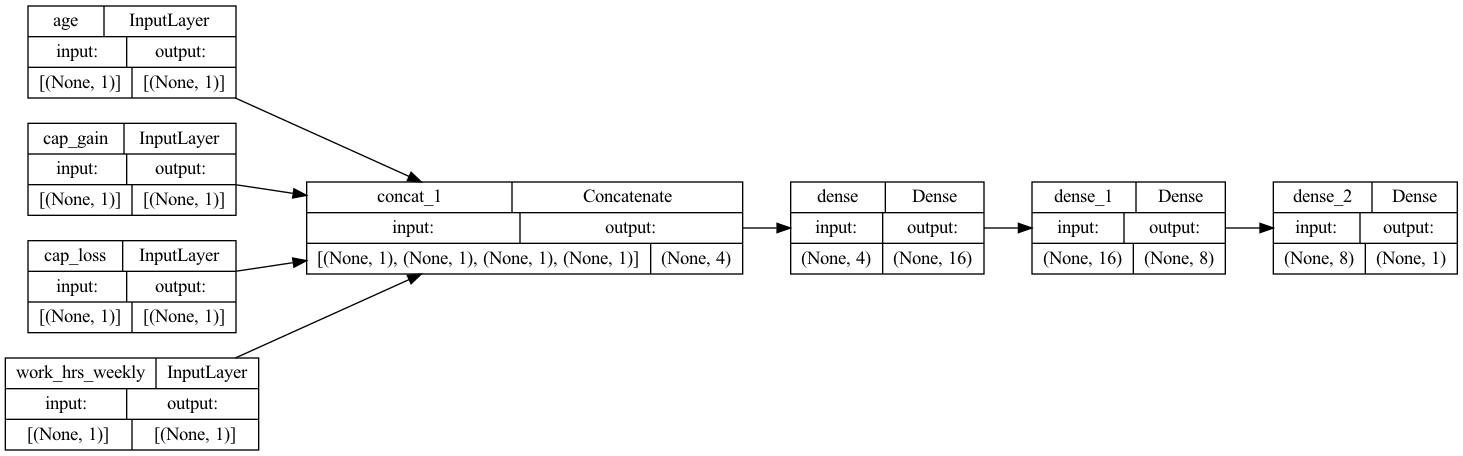

In [10]:
# To run this, you will need to install graphviz. Here are some good instructions:
#  https://eloquentcode.com/generate-a-diagram-for-a-keras-model-on-macos
plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [11]:
# import the loss function we plan to use
from tensorflow.keras.losses import binary_crossentropy
# import a built in optimizer
# I am using legacy for an M1 chipset speed
from tensorflow.keras.optimizers.legacy import Adam

opt = Adam() #default optimizer parameters
num_epochs = 5

for e in range(num_epochs):
    # iterating over this is one full epoch
    for (features,labels) in ds_train: # use tf.data iterator
        
        # here features is a dictionary of the variables
        # now the features and labels are for one batch
        with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
            # put through the model
            yhat = training_model(features)
            
            # get the loss function
            # squeeze operation gets rid of extra dimensions that are unneeded
            loss = binary_crossentropy(tf.squeeze(labels), tf.squeeze(yhat))

        # update via auto diff and specified optimizer
        # get the gradients according to the loss function with respect to all variables
        grads = tape.gradient(loss, training_model.trainable_variables)
        # apply those gradients to the variables, this updates the trainiable weights
        opt.apply_gradients(zip(grads, training_model.trainable_variables))
        
    # at the end of the epoch, print results on validation set
    # here we can see that many funcitons have a numpy equivalent 
    num_points = 0
    num_correct = 0
    for (features,labels) in ds_test:
        num_points += len(labels.numpy())
        yhat_proba = training_model(features)
        yhat = tf.round(yhat_proba).numpy()
        
        num_correct += sum(np.squeeze(yhat)==labels.numpy())
        
    print(f'Finished epoch {e}, with validation accuracy: {num_correct/num_points}')
        

/Users/ghaidaatoum/anaconda3/envs/ML_Latest/lib/python3.8/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'country'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Finished epoch 0, with validation accuracy: 0.7543160690571049
Finished epoch 1, with validation accuracy: 0.7543160690571049
Finished epoch 2, with validation accuracy: 0.7543160690571049
Finished epoch 3, with validation accuracy: 0.7543160690571049
Finished epoch 4, with validation accuracy: 0.7543160690571049


### Using the .fit
Of course, we do not need to run so many operations ourselves, keras has a function for fitting to the data but it hides many of the operations that are more explicit above...

In [12]:
# Before using the fit function, the model needs some additional 
# information, which we can add by compiling it
training_model.compile(
    optimizer="adam", 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

In [13]:
# we can also just use some built in fitting functionality in keras, 
# if we do not want to  control all the ways in which gradients, etc. are used
history = training_model.fit(
    ds_train, epochs=5, validation_data=ds_test, verbose=2
)

Epoch 1/5


2023-11-15 20:13:50.711468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:13:56.974813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 - 9s - loss: 8.3480 - accuracy: 0.6890 - val_loss: 0.8954 - val_accuracy: 0.7540 - 9s/epoch - 19ms/step
Epoch 2/5
472/472 - 4s - loss: 4.5993 - accuracy: 0.7798 - val_loss: 2.9009 - val_accuracy: 0.7946 - 4s/epoch - 8ms/step
Epoch 3/5
472/472 - 4s - loss: 3.0938 - accuracy: 0.7840 - val_loss: 1.9805 - val_accuracy: 0.7868 - 4s/epoch - 8ms/step
Epoch 4/5
472/472 - 4s - loss: 4.7728 - accuracy: 0.7780 - val_loss: 4.7812 - val_accuracy: 0.7725 - 4s/epoch - 8ms/step
Epoch 5/5
472/472 - 4s - loss: 5.7055 - accuracy: 0.7822 - val_loss: 4.4732 - val_accuracy: 0.7922 - 4s/epoch - 8ms/step


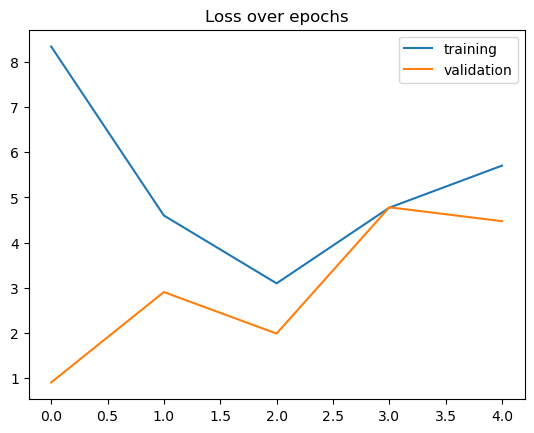

In [14]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.title('Loss over epochs')
plt.show()

## Using Feature Spaces in Keras
Feature spaces are a part of keras and tensorflow that allow for specifying how data should be pre-processed before being input into the model. They also prvoide a really convenient way to get tensors for the models. 


Feature spaces allow us to perform pre-processing on the tf.dataset specifically for each input we have. It even allows us to:
- keep the string variables and encode them into categories
- make numeric data discrete
- normalize numeric features such that they are more similar dynamic ranges. These normalized 
- The outputs can be concatenated or can remain separate dictionary features after processing. 

The `map` function allows us to tell the tf.dataset that these feature spaces need to be processed as part of the pipeline.

In [15]:
from tensorflow.keras.utils import FeatureSpace

# Example One: Just lump everything together, and concatenate
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "workclass": FeatureSpace.string_categorical(num_oov_indices=0),
        "education": FeatureSpace.string_categorical(num_oov_indices=0),
        "marital_status": FeatureSpace.string_categorical(num_oov_indices=0),
        "occupation": FeatureSpace.string_categorical(num_oov_indices=0),
        "relationship": FeatureSpace.string_categorical(num_oov_indices=0),
        "race": FeatureSpace.string_categorical(num_oov_indices=0),
        "sex": FeatureSpace.string_categorical(num_oov_indices=0),
        "country": FeatureSpace.string_categorical(num_oov_indices=0),
        
        # Numerical features to make discrete, make into integer with max val
        "age": FeatureSpace.float_discretized(num_bins=10),
        
        # Numerical features to normalize (normalization will be learned)
        # learns the mean, variance, and if to invert (3 parameters)
        "cap_gain": FeatureSpace.float_normalized(),
        "cap_loss": FeatureSpace.float_normalized(),
        "work_hrs_weekly": FeatureSpace.float_normalized(),
    },
    output_mode="concat", # can also be a dict, processed internally
)



# now that we have specified the preprocessing, let's run it on the data

# create a version of the dataset that can be iterated without labels
train_ds_with_no_labels = ds_train.map(lambda x, _: x)  
feature_space.adapt(train_ds_with_no_labels) # inititalize the feature map to this data
# the adapt function allows the model to learn one-hot encoding sizes

# now define a preprocessing operation that returns the processed features
preprocessed_ds_train = ds_train.map(lambda x, y: (feature_space(x), y), 
                                     num_parallel_calls=tf.data.AUTOTUNE)
# run it so that we can use the pre-processed data
preprocessed_ds_train = preprocessed_ds_train.prefetch(tf.data.AUTOTUNE)

# do the same for the test set
preprocessed_ds_test = ds_test.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test = preprocessed_ds_test.prefetch(tf.data.AUTOTUNE)

2023-11-15 20:14:14.718179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:14:15.192217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:14:15.601686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:14:15.960782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:14:16.369783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:14:16.758331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:14:17.125957: I tensorflow/core/grappler/optimizers/cust

### Using Keras multiple models into Computation Graph
Now that we have some pre-processing completed, we have the option of providing a Keras model with the input data before or after the feature space transforms are applied. That is, we could:
- 1. Give the `ds_train` tf.dataset directly, but we would need to apply the feature space transforms to each batch. This is easy, but slows down our processing
- 2. Give the already preprocessed version, `preprocessed_ds_train` and let the model learn form these already processed models. This is fast.

We do not need to choose. We can create two models, one that expects non-preprocessed data and another that does expect the data to already be processed. 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 country (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 education (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 marital_status (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                          

 category_encoding_7 (Categ  (None, 2)                    0         ['string_categorical_7_preproc
 oryEncoding)                                                       essor[0][0]']                 
                                                                                                  
 float_normalized_3_preproc  (None, 1)                    3         ['work_hrs_weekly[0][0]']     
 essor (Normalization)                                                                            
                                                                                                  
 category_encoding_8 (Categ  (None, 7)                    0         ['string_categorical_1_preproc
 oryEncoding)                                                       essor[0][0]']                 
                                                                                                  
 concatenate (Concatenate)   (None, 111)                  0         ['category_encoding[0][0]',   
          

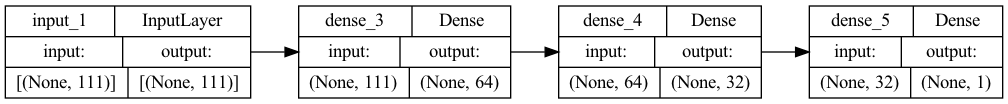

In [16]:
# these are the placeholder inputs in the computation graph BEFORE 
# applying and transformations
dict_inputs = feature_space.get_inputs() # getting inputs is WAY easier now

# these are the encoded features after they have been processed
# We can use these as additional inpits into the computation graph
encoded_features = feature_space.get_encoded_features() # these features have been encoded
# using feature space above, this will result in 131 concatenated features
# this is calucalted based on the one-hot encodings for each category

# now lets create some layers with Keras
x = keras.layers.Dense(64, activation="relu")(encoded_features)
x = keras.layers.Dense(32, activation="relu")(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

# we can now create two input/outputs to the computation graph

# this expects features already transformed
training_model = keras.Model(inputs=encoded_features, 
                             outputs=predictions)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

# this expects features that are not transformed 
inference_model = keras.Model(inputs=dict_inputs, 
                              outputs=predictions)
inference_model.compile(loss="binary_crossentropy", metrics=["accuracy"])

inference_model.summary()

plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

There are SO MANY parameters in this, wow. This is becasue we are simply throwing everything together into one big network. Let's try and train this, even though the model is very large. 

In [17]:
# train using the already processed features
history = training_model.fit(
    preprocessed_ds_train, epochs=5, validation_data=preprocessed_ds_test, verbose=2
)

Epoch 1/5


2023-11-15 20:14:30.263613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:14:36.673357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 - 9s - loss: 0.3432 - accuracy: 0.8388 - val_loss: 0.3290 - val_accuracy: 0.8444 - 9s/epoch - 20ms/step
Epoch 2/5
472/472 - 4s - loss: 0.3224 - accuracy: 0.8497 - val_loss: 0.3272 - val_accuracy: 0.8463 - 4s/epoch - 8ms/step
Epoch 3/5
472/472 - 4s - loss: 0.3224 - accuracy: 0.8508 - val_loss: 0.3310 - val_accuracy: 0.8434 - 4s/epoch - 8ms/step
Epoch 4/5
472/472 - 4s - loss: 0.3235 - accuracy: 0.8501 - val_loss: 0.3317 - val_accuracy: 0.8437 - 4s/epoch - 8ms/step
Epoch 5/5
472/472 - 4s - loss: 0.3250 - accuracy: 0.8489 - val_loss: 0.3284 - val_accuracy: 0.8457 - 4s/epoch - 8ms/step


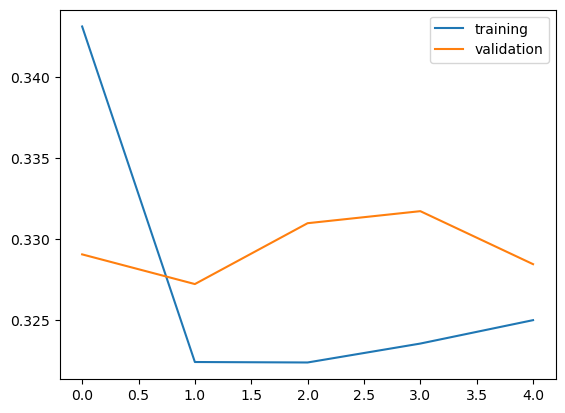

In [18]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()

In [19]:
# can also run evaluation, batch by batch and aggregate the results
inference_model.evaluate(ds_test)

2023-11-15 20:14:55.135027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


236/236 [==============================] - 6s 15ms/step - loss: 0.3284 - accuracy: 0.8457


[0.3284386396408081, 0.8456839323043823]

___
# Adding Customization to the Model 
For this particular optimization, we want to add some cusotmization in the way we process the data, perhaps even allowing the model to have many fewer parameters. 

Lets start by using embeddings for each input categorical feature. 

**[back to slides]**

## Embedding Categorical Data
In order to add one-hot encoding, we need to separate the categorical features that are currently saved as integers and place them into Embedding layers. An embedding layer deals with integers as if they were one-hot encoded. To start, let's only create a model from these categorical variables. 

- The first decision to make is about the size of the dense feature embeddings. This is essentially a dimensionality reduction step. 
 - This can be difficult to set, but one common setting is $\log_2(N)$ or $\sqrt{N}$ where $N$ is the total number of uniques values.
- When using an Embedding, we can leave the variables represented as integers. That is, keras will use the integer representation to figure out how to one-hot-encode the variable. This is great because it means we don't need to change the variable in memory.


In [20]:
from tensorflow.keras.layers import Embedding, Flatten

def setup_embedding_from_categorical(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = len(feature_space.preprocessors[col_name].get_vocabulary())
    
    # get the output from the feature space, which is input to embedding
    x = feature_space.preprocessors[col_name].output
    
    # now use an embedding to deal with integers from feature space
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x # return the tensor here 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 workclass (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 education (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 marital_status (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 occupation (InputLayer)     [(None, 1)]                  0         []                      

 float_normalized_2_preproc  (None, 1)                    3         ['cap_loss[0][0]']            
 essor (Normalization)                                                                            
                                                                                                  
 float_normalized_3_preproc  (None, 1)                    3         ['work_hrs_weekly[0][0]']     
 essor (Normalization)                                                                            
                                                                                                  
 flatten (Flatten)           (None, 2)                    0         ['workclass_embed[0][0]']     
                                                                                                  
 flatten_1 (Flatten)         (None, 4)                    0         ['education_embed[0][0]']     
                                                                                                  
 flatten_2

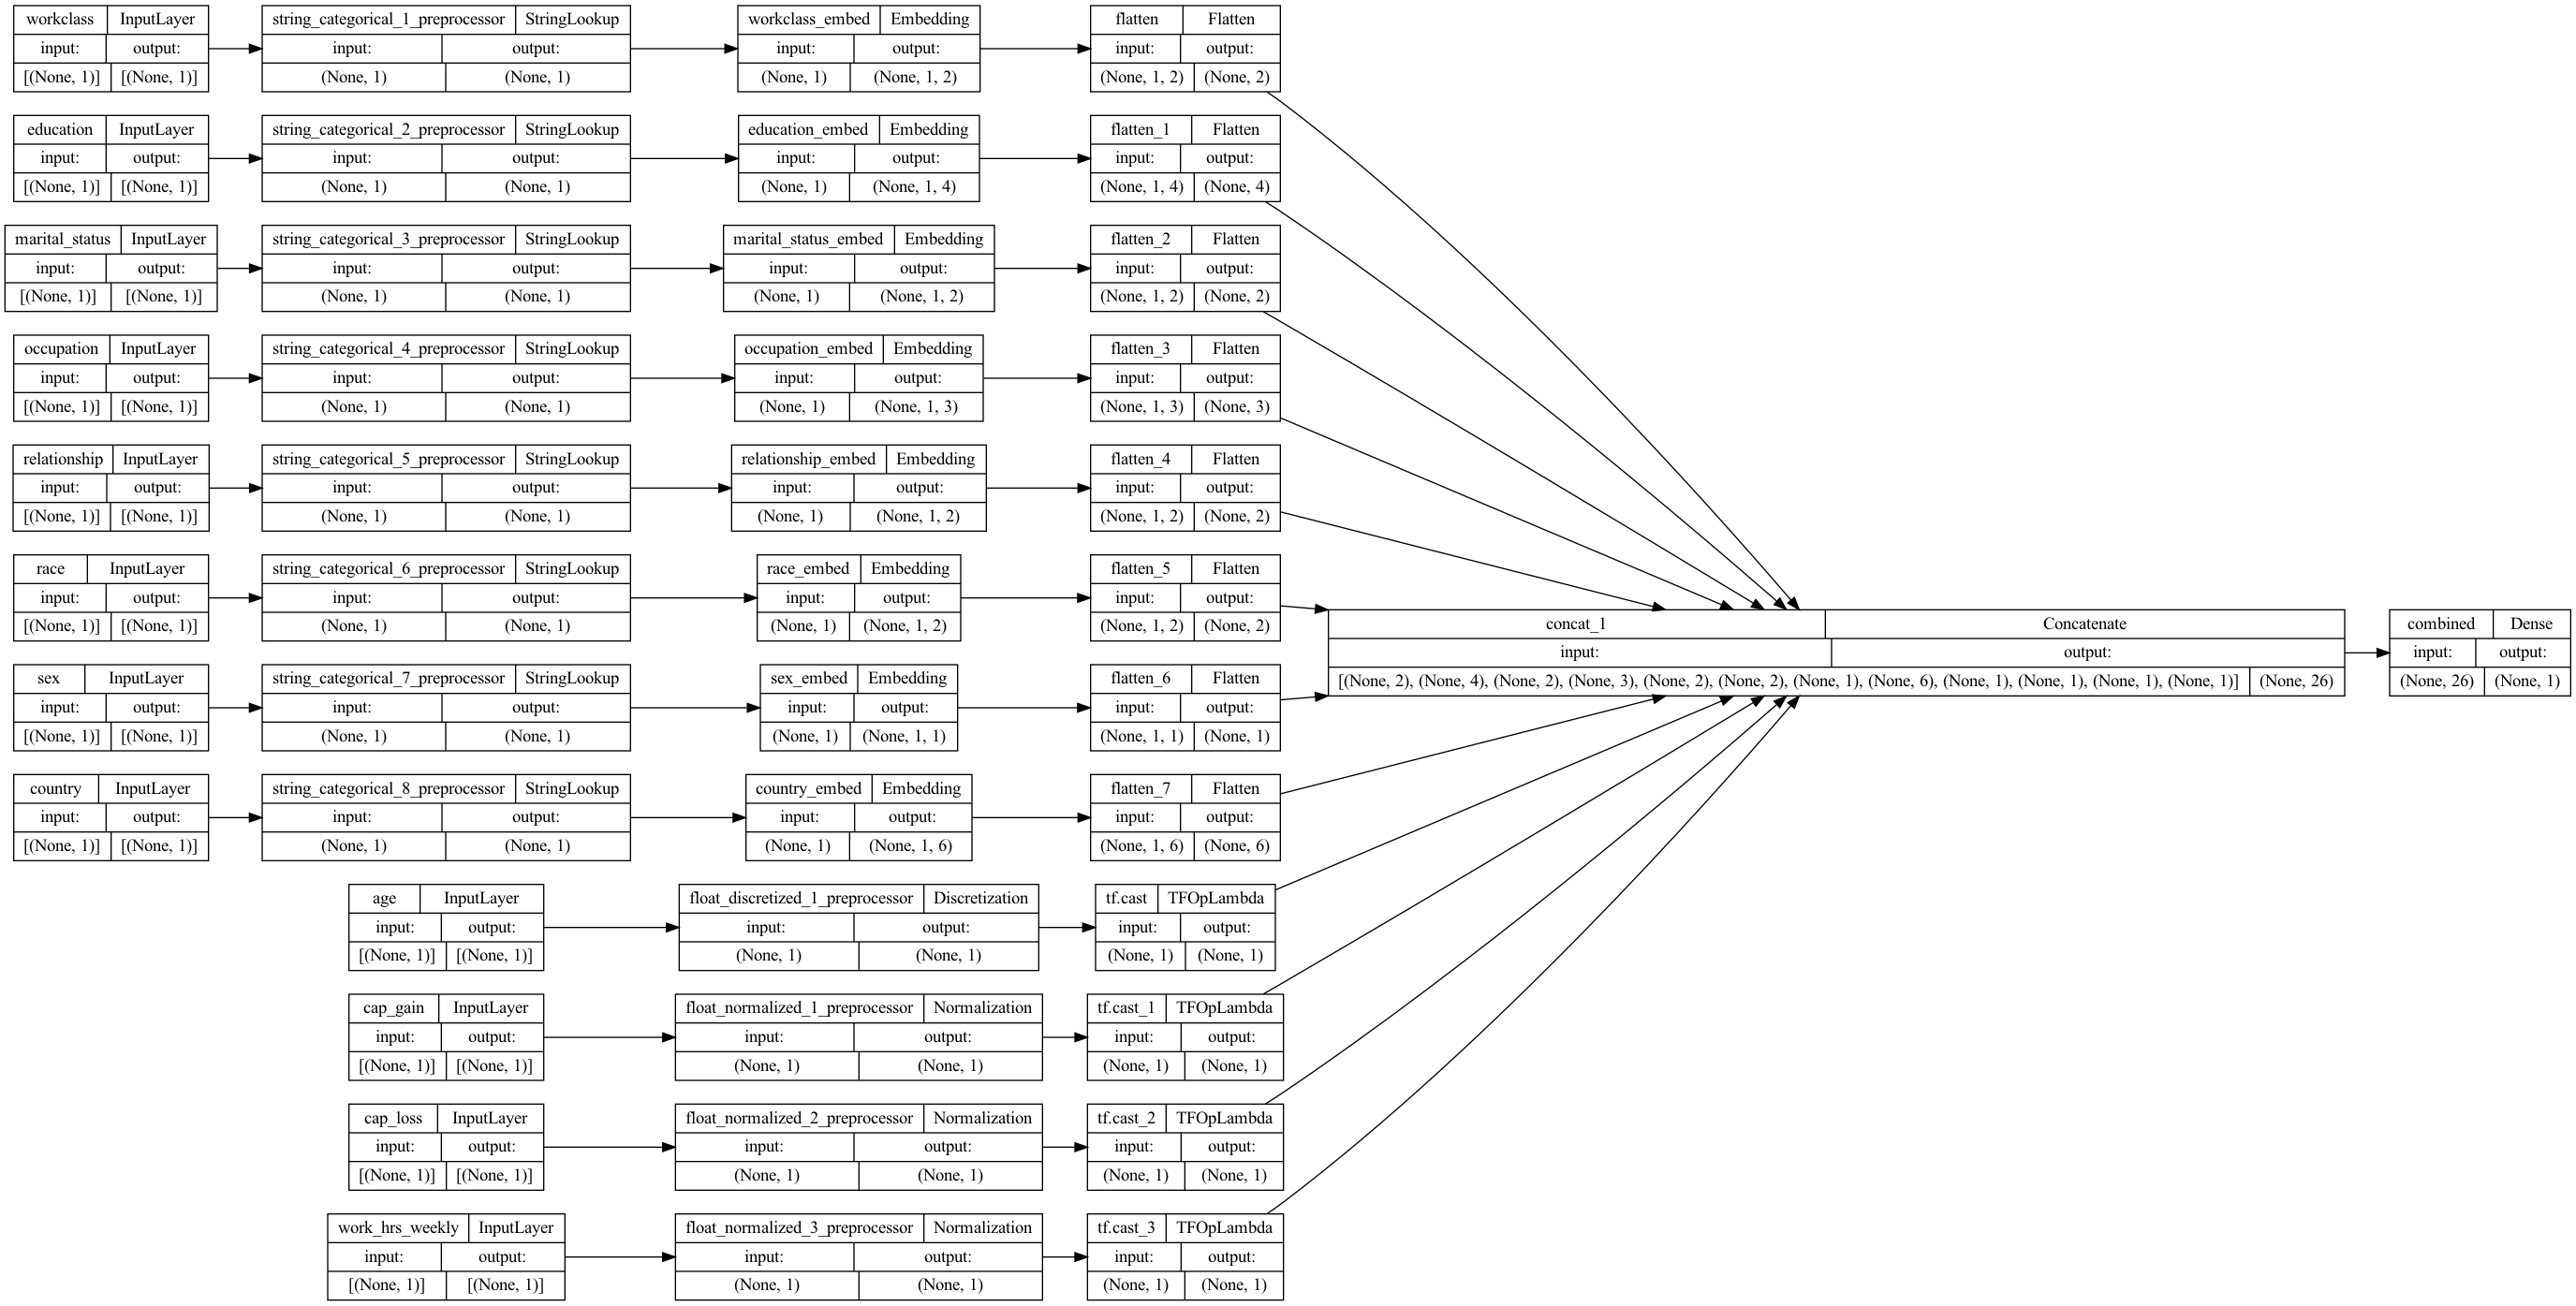

In [21]:
    
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output

# some lists for keeping track of parts of the model
all_branch_outputs = [] # this is where we will keep track of output of each branch

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)
    
    # save these outputs in list to concatenate later
    all_branch_outputs.append(x)
    
    
# for each numeric variable, just add it in after embedding
for col in numeric_headers:
    x = feature_space.preprocessors[col].output
    x = tf.cast(x,float) # cast an integer as a float here
    all_branch_outputs.append(x)
    
# now concatenate the outputs and add a fully connected layer
final_branch = Concatenate(name='concat_1')(all_branch_outputs)
final_branch = Dense(units=1,
                     activation='sigmoid', 
                     name='combined')(final_branch)

# here, since we are accessing the string lookup data directly, 
#. we cannot use the already processed data
training_model = keras.Model(inputs=dict_inputs, 
                             outputs=final_branch)

training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

training_model.summary()

plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [22]:
history = training_model.fit(
    ds_train, epochs=5, validation_data=ds_test, verbose=2
)

Epoch 1/5


2023-11-15 20:15:02.714362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:15:27.159449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 - 29s - loss: 0.4985 - accuracy: 0.7449 - val_loss: 0.3680 - val_accuracy: 0.8334 - 29s/epoch - 62ms/step
Epoch 2/5
472/472 - 10s - loss: 0.3514 - accuracy: 0.8381 - val_loss: 0.3403 - val_accuracy: 0.8418 - 10s/epoch - 22ms/step
Epoch 3/5
472/472 - 10s - loss: 0.3373 - accuracy: 0.8433 - val_loss: 0.3331 - val_accuracy: 0.8448 - 10s/epoch - 21ms/step
Epoch 4/5
472/472 - 10s - loss: 0.3318 - accuracy: 0.8461 - val_loss: 0.3298 - val_accuracy: 0.8461 - 10s/epoch - 21ms/step
Epoch 5/5
472/472 - 10s - loss: 0.3287 - accuracy: 0.8474 - val_loss: 0.3280 - val_accuracy: 0.8474 - 10s/epoch - 20ms/step


# Crossed Columns and Deep Embeddings
Lets create the network below in steps. This network consists of a number of different paths for the input data to take.
![asdfasfd](https://www.tensorflow.org/images/wide_n_deep.svg)

 ___


## Making Crossed Columns
For this example, we are going to make embeddings for crossed columns. Tensorflow `feature_space` makes this operation very simple. 

In the model we will have: 
- branches of categorical features as input 
- branches of features that will be crossed
- branches of numeric data input



In [23]:
from tensorflow.keras.utils import FeatureSpace

# Crossing columns together 
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "workclass": FeatureSpace.string_categorical(num_oov_indices=0),
        "education": FeatureSpace.string_categorical(num_oov_indices=0),
        "marital_status": FeatureSpace.string_categorical(num_oov_indices=0),
        "occupation": FeatureSpace.string_categorical(num_oov_indices=0),
        "relationship": FeatureSpace.string_categorical(num_oov_indices=0),
        "race": FeatureSpace.string_categorical(num_oov_indices=0),
        "sex": FeatureSpace.string_categorical(num_oov_indices=0),
        "country": FeatureSpace.string_categorical(num_oov_indices=0),
        
        # Numerical features to make discrete, make into integer with max val
        "age": FeatureSpace.float_discretized(num_bins=30),
        
        # Numerical features to normalize (normalization will be learned)
        # learns the mean, variance, and if to invert (3 parameters)
        "cap_gain": FeatureSpace.float_normalized(),
        "cap_loss": FeatureSpace.float_normalized(),
        "work_hrs_weekly": FeatureSpace.float_normalized(),
    },
    # Specify feature cross with a custom crossing dim
    crosses=[
        FeatureSpace.cross(
            feature_names=('workclass','occupation'), # dims: 7 x 14 = 
            crossing_dim=7*14),
        FeatureSpace.cross(
            feature_names=('marital_status','sex','race'), # 7 x 2 x 5
            crossing_dim=7*2*5),
        FeatureSpace.cross(
            feature_names=('occupation','education'), # 14 x 16
            crossing_dim=14*16),
    ],
    output_mode="concat",
)
# workclass has 7 unique values.
# education has 16 unique values.
# marital_status has 7 unique values.
# occupation has 14 unique values.
# relationship has 6 unique values.
# race has 5 unique values.
# sex has 2 unique values.
# country has 41 unique values.

# add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

2023-11-15 20:16:10.954310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:16:11.304982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:16:11.647869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:16:11.985936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:16:12.352654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:16:12.696629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:16:13.071348: I tensorflow/core/grappler/optimizers/cust

In [24]:
def setup_embedding_from_crossing(feature_space, col_name):
    # what the maximum integer value for this variable?
    
    # get the size of the feature
    N = feature_space.crossers[col_name].num_bins
    x = feature_space.crossers[col_name].output
    
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x

___


## Combining Crossed Linear Classifier and Deep Embeddings
Now its just a matter of setting the wide and deep columns for tensorflow. After which, we can use the combined classifier!

Wide and deep models can have really interesting and useful properties so they are great to keep in mind when selecting an architecture. Some of the hyperparameters that are specific to this are:
- which features to cross together, typically you only want to cross columns you think are important to be connected--they somehow might create new knowledge by combining.
- the size of the dense feature embeddings. This can be difficult to set, but one common setting is $log_2(N)$ or $\sqrt{N}$ where $N$ is the total number of uniques values.

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 workclass (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 education (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 marital_status (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 occupation (InputLayer)     [(None, 1)]                  0         []                      

 sex_embed (Embedding)       (None, 1, 1)                 2         ['string_categorical_15_prepro
                                                                    cessor[0][0]']                
                                                                                                  
 country_embed (Embedding)   (None, 1, 6)                 246       ['string_categorical_16_prepro
                                                                    cessor[0][0]']                
                                                                                                  
 tf.cast_4 (TFOpLambda)      (None, 1)                    0         ['float_discretized_2_preproce
                                                                    ssor[0][0]']                  
                                                                                                  
 tf.cast_5 (TFOpLambda)      (None, 1)                    0         ['float_normalized_4_preproces
          

 flatten_10 (Flatten)        (None, 14)                   0         ['occupation_X_education_embed
                                                                    [0][0]']                      
                                                                                                  
 deep3 (Dense)               (None, 10)                   260       ['deep2[0][0]']               
                                                                                                  
 wide_concat (Concatenate)   (None, 31)                   0         ['flatten_8[0][0]',           
                                                                     'flatten_9[0][0]',           
                                                                     'flatten_10[0][0]']          
                                                                                                  
 concat_deep_wide (Concaten  (None, 41)                   0         ['deep3[0][0]',               
 ate)     

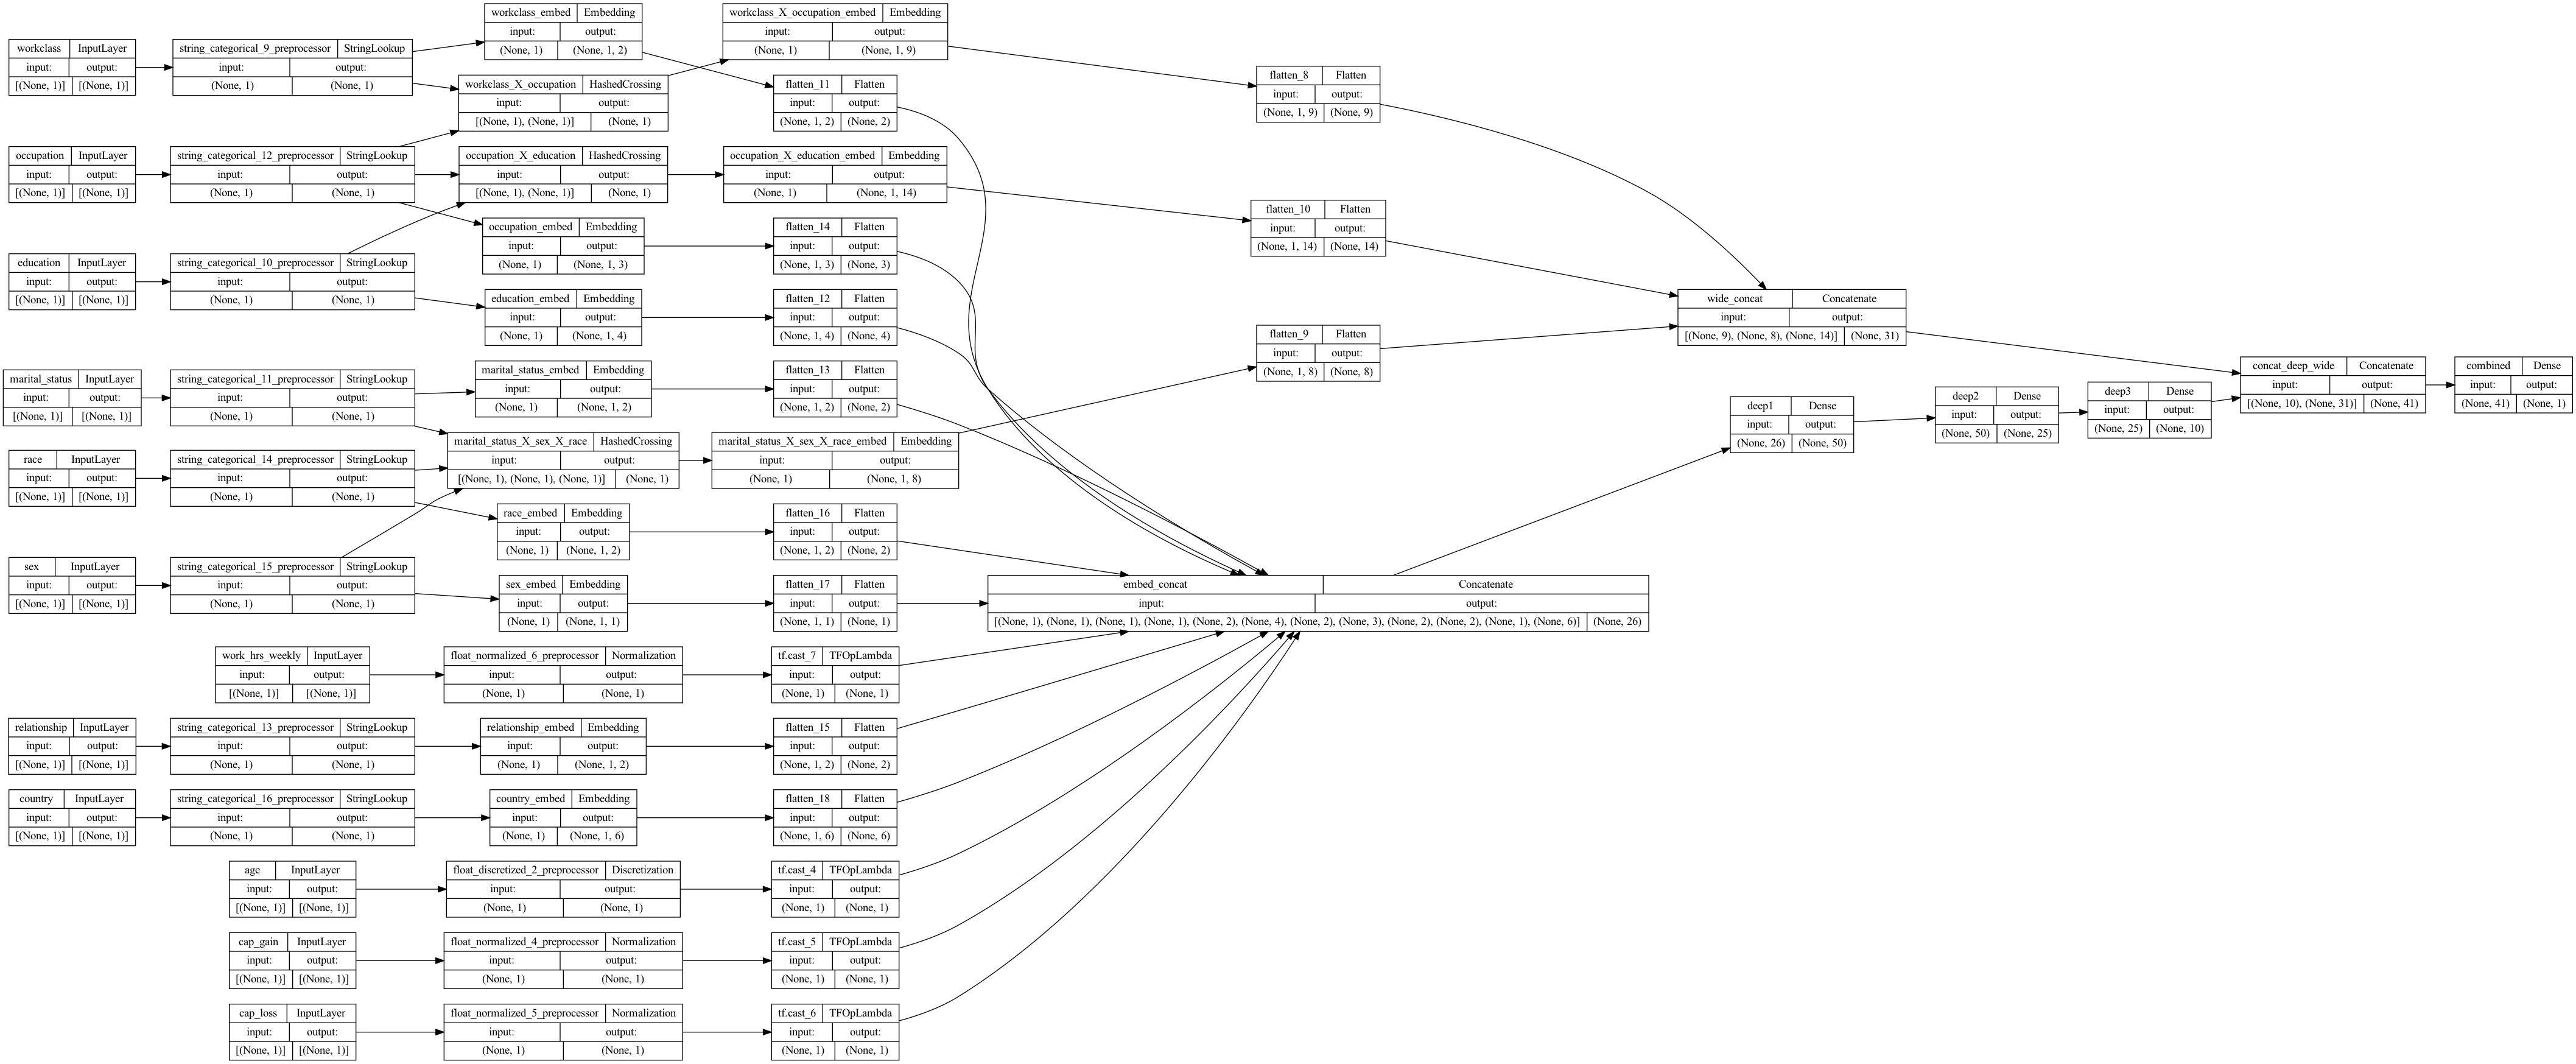

In [25]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output

# we need to create separate lists for each branch
crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_crossing(feature_space, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each numeric variable, just add it in after embedding
for idx,col in enumerate(numeric_headers):
    x = feature_space.preprocessors[col].output
    x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)
    
# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)
    
    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)


# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

training_model.summary()

plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [26]:
history = training_model.fit(
    ds_train, epochs=5, validation_data=ds_test, verbose=2
)

Epoch 1/5


2023-11-15 20:16:27.055972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 20:17:06.039876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 - 45s - loss: 0.4192 - accuracy: 0.8055 - val_loss: 0.3378 - val_accuracy: 0.8392 - 45s/epoch - 95ms/step
Epoch 2/5
472/472 - 13s - loss: 0.3317 - accuracy: 0.8457 - val_loss: 0.3378 - val_accuracy: 0.8384 - 13s/epoch - 28ms/step
Epoch 3/5
472/472 - 13s - loss: 0.3290 - accuracy: 0.8469 - val_loss: 0.3338 - val_accuracy: 0.8438 - 13s/epoch - 27ms/step
Epoch 4/5
472/472 - 13s - loss: 0.3304 - accuracy: 0.8472 - val_loss: 0.3292 - val_accuracy: 0.8452 - 13s/epoch - 27ms/step
Epoch 5/5
472/472 - 13s - loss: 0.3339 - accuracy: 0.8438 - val_loss: 0.3690 - val_accuracy: 0.8314 - 13s/epoch - 27ms/step


Text(0.5, 0, 'epochs')

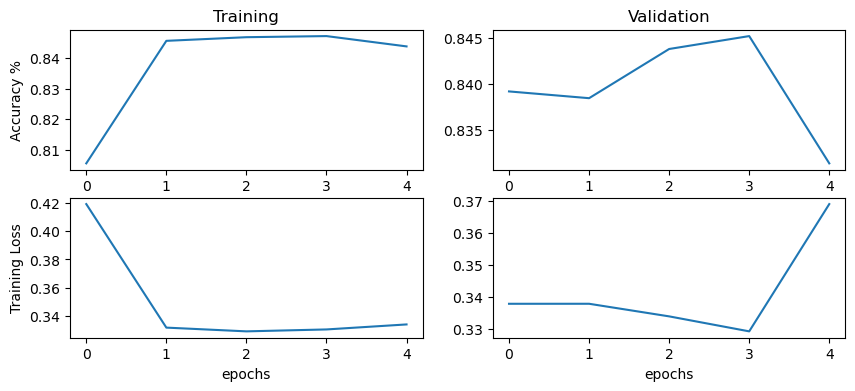

In [27]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

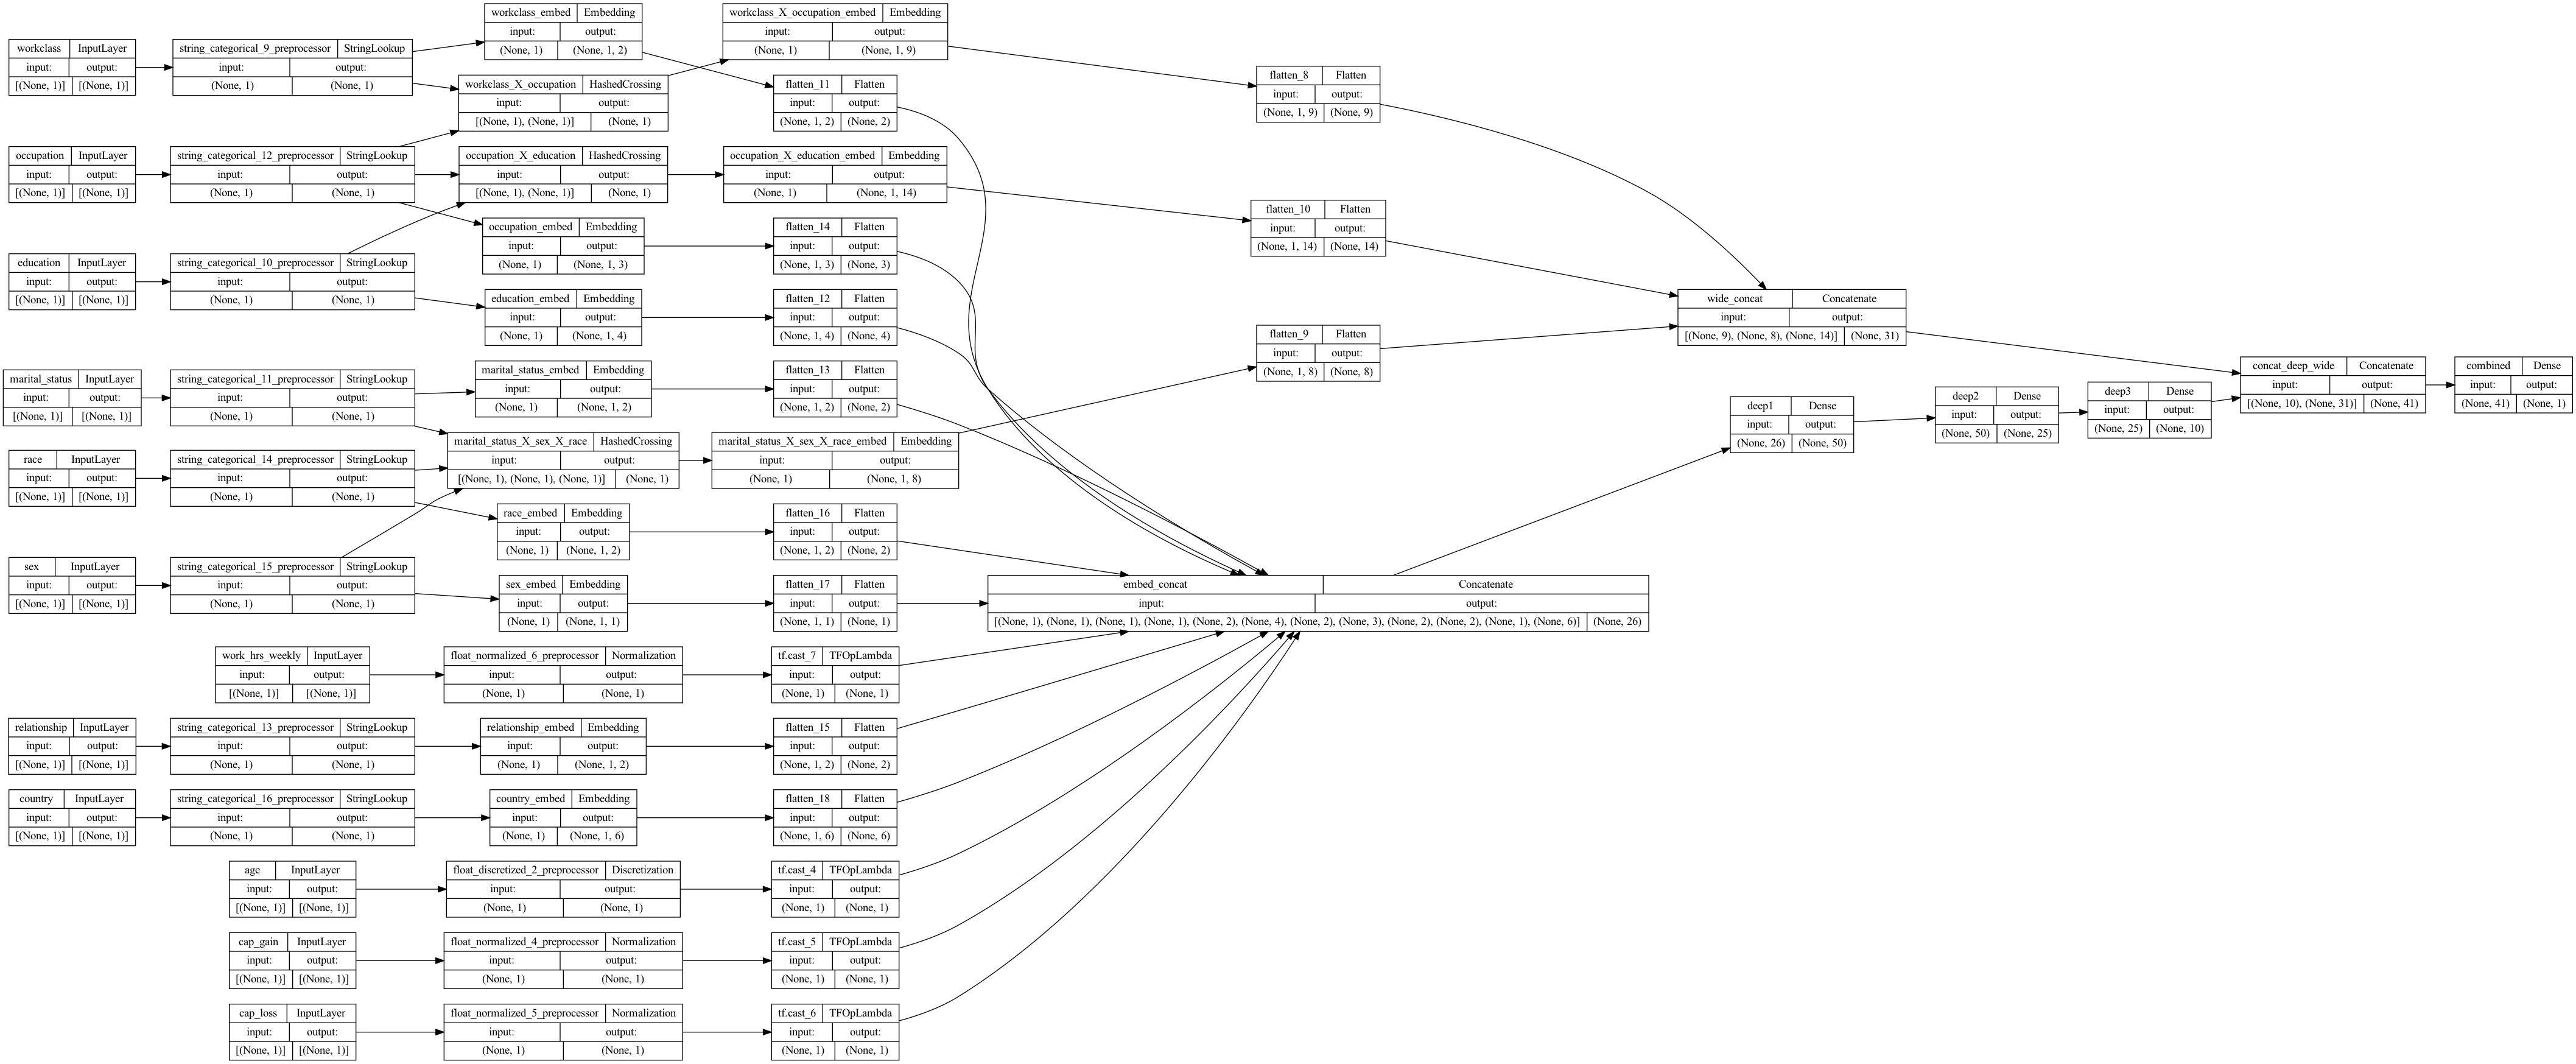

In [28]:
plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

___________

# Additional Performance Metrics
We can also use all the sklearn metrics we are accustomed to, but we need to get a numpy array of data in order to do this, as follows:

In [29]:
# we only need to do this to use sklearn metrics 
y_test = tf.concat([y for x, y in ds_test], axis=0)
y_test = y_test.numpy()
y_test

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
# Use the sklearn metrics here, if you want to
from sklearn import metrics as mt

# now lets see how well the model performed
yhat_proba = training_model.predict(ds_test) # sigmoid output probabilities
# use squeeze to get rid of any extra dimensions 
yhat = np.round(yhat_proba.squeeze()) # round to get binary class

print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

# Making Generalization Better
In what ways might we try to make the model found generalize more concretely?

**Self Test:** What is the best method to make the results better?  
- A. Add Dropout to deep network
- B. Add Dropout to wide network
- C. Perturb the Categorical Data during Training (augmentation)
- D. Add L2 regularization to different layer's weights


# In this Notebook You Learned
- The keras API
- Embedding layers in keras
- Wide and Deep networks

# Speeding up Processing using Custom Pre-Processor
Bonus: in the blocks below, I show how you can perform the same network as above, but can employ the use of pre-processing in `tf.data` records. This means that all the string look ups and feature crossing is pre-computed, saving a TON of resources that would be needless. 

In order to do this, we need to change our method of feature space usage a little bit. 

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import metrics as mt
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from tensorflow.keras.utils import FeatureSpace

# Crossing columns together 
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "workclass": FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        "education": FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        "marital_status": FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        "occupation": FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        "relationship": FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        "race": FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        "sex": FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        "country": FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        
        # Numerical features to make discrete, make into integer with max val
        "age": FeatureSpace.float_discretized(num_bins=30),
        
        # Numerical features to normalize (normalization will be learned)
        # learns the mean, variance, and if to invert (3 parameters)
        "cap_gain": FeatureSpace.float_normalized(),
        "cap_loss": FeatureSpace.float_normalized(),
        "work_hrs_weekly": FeatureSpace.float_normalized(),
    },
    # Specify feature cross with a custom crossing dim
    crosses=[
        FeatureSpace.cross(
            feature_names=('workclass','occupation'), # dims: 7 x 14 = 
            crossing_dim=7*14, output_mode='int'),
        FeatureSpace.cross(
            feature_names=('marital_status','sex','race'), # 7 x 2 x 5
            crossing_dim=7*2*5, output_mode='int'),
    ],
    output_mode="dict",
)
# workclass has 7 unique values.
# education has 16 unique values.
# marital_status has 7 unique values.
# occupation has 14 unique values.
# relationship has 6 unique values.
# race has 5 unique values.
# sex has 2 unique values.
# country has 41 unique values.

# add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

preprocessed_ds_train = ds_train.map(lambda x, y: (feature_space(x), y), 
                                     num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_train = preprocessed_ds_train.prefetch(tf.data.AUTOTUNE)

preprocessed_ds_test = ds_test.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test = preprocessed_ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
def setup_embedding_from_encoding(encoded_features, col_name):
    # what the maximum integer value for this variable?
    
    # get the size of the feature
    x = encoded_features[col_name]
    N = x.shape[1]
    
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x


dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

# we need to create separate lists for each branch
crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each numeric variable, just add it in after embedding
for col in numeric_headers:
    x = encoded_features[col]
    #x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)
    
# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)


# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

# encoded features input, fast
training_model = keras.Model(inputs=encoded_features, outputs=final_branch)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.FBetaScore(beta=2.0, threshold=0.5)]
)

training_model.summary()

# non-encoded, perform redundant operations
inference_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
inference_model.compile(loss="binary_crossentropy", metrics=["accuracy"])


plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
history = training_model.fit(
    preprocessed_ds_train, epochs=10, validation_data=preprocessed_ds_test, verbose=2
)